In [209]:
#Importing some necessary packages

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='once')

### Define functions

In [211]:
# A function that allows us to drop rows based on values we think are suspect

def drop_anomolous_rows(df, colname, val):
    return df[df[colname] != val]

In [212]:
# A function to take columns with years (yr_built, yr_renovated) and bin them by decade

from sklearn.preprocessing import LabelEncoder

def bin_by_decade(df, colname):
    bins = pd.IntervalIndex.from_tuples([(1900, 1909), (1910, 1919), (1920, 1929), (1930, 1939), (1940, 1949), (1950, 1959), (1960, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2010), (2010, 2020)])
    series = pd.cut(df[colname], bins)
    df[colname] = series
    return df

In [214]:
# Contains all of our data cleaning operations

def clean():
    
# Load the data
    
    house = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-dc-ds-career-042219/master/kc_house_data.csv')
    
# Get rid of rows
    # The row with 33 bedrooms is a suspicious outlier, so we decided to drop it
    # The 454 ?s in sqft_basement needed to be remedied. We chose to drop them--454 seemed like too many to impute. 

    clean_house = drop_anomolous_rows(house, 'bedrooms', 33)
    clean_house = drop_anomolous_rows(house, 'sqft_basement', "?")
    
# Bin decades
    
    clean_house = bin_by_decade(clean_house, 'yr_built')
    clean_house = bin_by_decade(clean_house, 'yr_renovated')
    
# Get dummies

    clean_house = pd.get_dummies(clean_house, columns=(['view', 'floors', 'bedrooms', 'condition', 'zipcode', 'yr_built', 'yr_renovated']))
    
# Drop id, date, waterfront

    clean_house = clean_house.drop(['id', 'date', 'waterfront'], axis=1)
    
# Convert sqft_basement from object to float

    clean_house['sqft_basement'] = clean_house['sqft_basement'].astype(float, inplace=True)

# Return clean_house
    
    return clean_house

### Get clean dataframe

In [216]:
clean_house = clean()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [217]:
clean_house.head()

,price,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,lat,long,sqft_living15,...,"yr_renovated_(1920, 1929]","yr_renovated_(1930, 1939]","yr_renovated_(1940, 1949]","yr_renovated_(1950, 1959]","yr_renovated_(1960, 1969]","yr_renovated_(1970, 1979]","yr_renovated_(1980, 1989]","yr_renovated_(1990, 1999]","yr_renovated_(2000, 2010]","yr_renovated_(2010, 2020]"
0,221900.0,1.00,1180,5650,7,1180,0.0,47.5112,-122.257,1340,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,2.25,2570,7242,7,2170,400.0,47.7210,-122.319,1690,...,0,0,0,0,0,0,0,1,0,0
2,180000.0,1.00,770,10000,6,770,0.0,47.7379,-122.233,2720,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,3.00,1960,5000,7,1050,910.0,47.5208,-122.393,1360,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,2.00,1680,8080,8,1680,0.0,47.6168,-122.045,1800,...,0,0,0,0,0,0,0,0,0,0


In [243]:
clean_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Columns: 133 entries, price to yr_renovated_(2010, 2020]
dtypes: float64(5), int64(6), uint8(122)
memory usage: 4.4 MB


### Split the data into training and test sets

In [218]:
from sklearn.model_selection import train_test_split

In [219]:
# Split data into train and test sets

X = clean_house.drop(["price"], axis=1) #predictors
y = clean_house["price"] #target

In [221]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=3)
print(len(X_test), len(X_train), len(y_test), len(y_train))

4229 16914 4229 16914


### Regression 1: Manual scaling and feature selection

In [244]:
import statsmodels.api as sm
from sklearn import preprocessing

# Used Scikitlearn's Standard Scaler
    # Takes each data point, subtracts the mean of the sample, then divides by the standard deviation of the sample

ss_scaler = preprocessing.StandardScaler()
clean_house_ss = ss_scaler.fit_transform(clean_house)

# Standard scaler returns a numpy array, so we converted it back to a DF

clean_house_ss = pd.DataFrame(clean_house_ss, columns=list(clean_house.columns))

# We generated a list of features to use using a stepwise selection function from Flatiron's learn.co lessons
    # Finds the best p values from your features

clean_house_selections_list = ['price', 'zipcode_98004', 'sqft_living', 'view_4.0', 'lat', 'zipcode_98039', 'zipcode_98112', 'zipcode_98040', 'view_0.0', 'zipcode_98105', 'zipcode_98119', 'zipcode_98199', 'zipcode_98102', 'zipcode_98109', 'zipcode_98033', 'zipcode_98006', 'zipcode_98103', 'zipcode_98122', 'zipcode_98115', 'zipcode_98117', 'zipcode_98107', 'zipcode_98116', 'zipcode_98144', 'zipcode_98005', 'zipcode_98136', 'view_3.0', 'zipcode_98029', 'sqft_lot', 'bedrooms_2', 'bedrooms_3', 'zipcode_98008', 'zipcode_98052', 'zipcode_98126', 'yr_renovated_(2000, 2010]', 'zipcode_98075', 'condition_5', 'zipcode_98007', 'zipcode_98027', 'zipcode_98074', 'zipcode_98118', 'yr_built_(2010, 2020]', 'zipcode_98019', 'bedrooms_1', 'bedrooms_4', 'floors_2.5', 'yr_built_(1970, 1979]', 'zipcode_98034', 'zipcode_98053', 'yr_built_(1960, 1969]', 'yr_built_(1950, 1959]', 'zipcode_98125', 'zipcode_98106', 'zipcode_98177', 'condition_4', 'bedrooms_5', 'yr_built_(1980, 1989]', 'bedrooms_6', 'zipcode_98014', 'zipcode_98059', 'zipcode_98028', 'yr_built_(1930, 1939]', 'zipcode_98178', 'condition_1', 'zipcode_98056', 'yr_renovated_(2010, 2020]', 'yr_built_(2000, 2010]', 'zipcode_98092', 'bedrooms_8', 'zipcode_98146', 'zipcode_98133', 'zipcode_98108', 'zipcode_98166', 'sqft_living15', 'yr_renovated_(1990, 1999]']

# Made a new DF with just the features from our selections list
clean_house_selections = clean_house_ss[clean_house_selections_list]

# Used statsmodels OLS so we could get a handy summary of the regression results
target = clean_house_selections["price"]
predictors = clean_house_selections.drop(["price"], axis=1)

predictors_int = sm.add_constant(predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     1050.
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        13:30:38   Log-Likelihood:                -13778.
No. Observations:               21143   AIC:                         2.770e+04
Df Residuals:                   21069   BIC:                         2.829e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -7.331e-15      0.003  -2.29e-12      1.000      -0.006       0.006
zipcode_98004                 0.2299      0.003     67.575      0.000       0.223       0.237
sqft_living                   0.5668      0.006     96.077      0.000       0.555       0.578
view_4.0                      0.1616      0.004     45.184      0.000       0.155       0.169
lat                           0.1296      0.005     25.147      0.000       0.119       0.140
zipcode_98039                 0.1636      0.003     50.391      0.000       0.157       0.170
zipcode_98112                 0.1587      0.003     46.990      0.000       0.152       0.165
zipcode_98040                 0.1462      0.003     43.366      0.000       0.140       0.153
view_0.0                     -0.0619      0.004    -14.770      0.000      -0.070      -0.054
zipcode_98105                 0.1013      0.003     29.917      0.000       0.095       0.108
zipcode_98119                 0.0967      0.003     29.078      0.000       0.090       0.103
zipcode_98199                 0.0917      0.003     26.673      0.000       0.085       0.098
zipcode_98102                 0.0781      0.003     23.857      0.000       0.072       0.084
zipcode_98109                 0.0765      0.003     23.380      0.000       0.070       0.083
zipcode_98033                 0.0988      0.003     28.276      0.000       0.092       0.106
zipcode_98006                 0.0812      0.003     23.679      0.000       0.074       0.088
zipcode_98103                 0.0971      0.004     26.316      0.000       0.090       0.104
zipcode_98122                 0.0782      0.003     23.208      0.000       0.072       0.085
zipcode_98115                 0.0877      0.004     23.994      0.000       0.081       0.095
zipcode_98117                 0.0812      0.004     22.123      0.000       0.074       0.088
zipcode_98107                 0.0684      0.003     19.976      0.000       0.062       0.075
zipcode_98116                 0.0614      0.003     18.271      0.000       0.055       0.068
zipcode_98144                 0.0602      0.003     17.845      0.000       0.054       0.067
zipcode_98005                 0.0575      0.003     17.426      0.000       0.051       0.064
zipcode_98136                 0.0494      0.003     14.924      0.000       0.043       0.056
view_3.0                      0.0389      0.004     10.428      0.000       0.032       0.046
zipcode_98029                 0.0482      0.003     14.531      0.000       0.042       0.055
sqft_lot                      0.0313      0.003      9.211      0.000       0.025       0.038
bedrooms_2                    0.2366      0.023     10.125      0.000       0.191       0.282
bedrooms_3                    0.3146      0.034      9.125      0.000      

### Model Validation

In [261]:
# We needed a special train, test, split for our altered data set

X1_train,X1_test,y1_train,y1_test=train_test_split(predictors,target,test_size=0.2,random_state=3)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X1_train, y1_train)

y_hat_train = linreg.predict(X1_train)
y_hat_test = linreg.predict(X1_test)

In [262]:
# Check the mean squared error

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 429058933051.83325
Test Mean Squarred Error: 421885504500.11163


In [225]:
# Cross validation scores
    # Took the mean cv score because cross_val_score returns a score for each fold

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results = np.mean(cross_val_score(linreg, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring="neg_mean_squared_error"))

In [226]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-2479266060903.6475
-51134517995614.92
-110293992294.40092


### Regression 2: Lasso

In [227]:
from sklearn.linear_model import Lasso

In [228]:
# Lasso Regression
    # Lasso helps prevent overfitting by reducing the influence of some of the predictors by penalizing their coefficients or reducing them to zero (effectively doing predictor selection)

lasso = Lasso()
lasso.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [229]:
# Checking the training/test scores (R2) of our model 

train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)

In [230]:
print("training score:", train_score)
print("test score: ", test_score)

training score: 0.8027047501603501
test score:  0.7928602503539883


In [247]:
# Checking to see how many features were used and how many were axed

coeff_used = np.sum(lasso.coef_!=0)
print("number of features used:", coeff_used)
print("number eliminated:", len(list(clean_house.columns)) - coeff_used)

number of features used: 128
number eliminated: 5


In [232]:
# Mean Squared Error

y_hat_train = lasso.predict(X_train)
y_hat_test = lasso.predict(X_test)

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 27113385027.536434
Test Mean Squarred Error: 26443217859.257618


In [233]:
# Cross Validation

cv_5_results = np.mean(cross_val_score(lasso, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(lasso, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(lasso, X, y, cv=20, scoring="neg_mean_squared_error"))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

In [234]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-27693483375.205437
-27658294254.329895
-27522365353.11402


### Regression 3: Ridge

In [235]:
from sklearn.linear_model import Ridge

In [236]:
# An important difference between Lasso and Ridge is that Ridge doesn't reduce any features' coefficient to 0 (though they can get very, very small)

ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [237]:
# Getting the scores

rtrain_score=ridge.score(X_train,y_train)
rtest_score=ridge.score(X_test,y_test)

In [238]:
print("training score:", rtrain_score)
print("test score: ", rtest_score)

training score: 0.8026624192010714
test score:  0.7931176177914419


In [239]:
# Mean Squared Error

y_hat_train = ridge.predict(X_train)
y_hat_test = ridge.predict(X_test)

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 27119202377.920914
Test Mean Squarred Error: 26410362633.5943


In [240]:
# Cross Validation

cv_5_results = np.mean(cross_val_score(ridge, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(ridge, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(ridge, X, y, cv=20, scoring="neg_mean_squared_error"))

In [241]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-27685705259.58349
-27650810513.546104
-27516502769.193916


### Try Gridsearch for best alpha

In [179]:
from sklearn.model_selection import GridSearchCV

In [180]:
param = {'alpha': [0.001, 0.01, 1, 5, 10, 20, 100]}

In [181]:
lasso_regressor = GridSearchCV(lasso, param, scoring='neg_mean_squared_error', cv=10)
lasso_regressor.fit(X, y)

print('Best parameters:', lasso_regressor.best_params_)
print('Best score:', lasso_regressor.best_score_)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Best parameters: {'alpha': 10}
Best score: -27647684480.672325


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [160]:
lasso = Lasso(alpha = 10)
lasso.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [161]:
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)

In [162]:
print("training score:", train_score)
print("test score: ", test_score)

training score: 0.802653962992103
test score:  0.7928680484020596


In [248]:
coeff_used = np.sum(lasso.coef_!=0)
print("number of features used:", coeff_used)
print("number eliminated:", len(list(clean_house.columns)) - coeff_used)

number of features used: 128
number eliminated: 5


In [242]:
# Mean Squared Error
y_hat_train = lasso.predict(X_train)
y_hat_test = lasso.predict(X_test)

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 27113385027.536434
Test Mean Squarred Error: 26443217859.257618


In [182]:
# Cross Validation

cv_5_results = np.mean(cross_val_score(lasso, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(lasso, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(lasso, X, y, cv=20, scoring="neg_mean_squared_error"))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

In [183]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-27687946315.46346
-27647276658.665264
-27512916557.359173


ValueError: x and y must be the same size

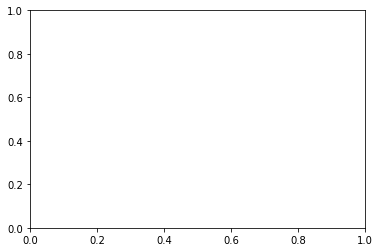

In [253]:
plt.scatter(X_test, y_test,  color='green')
plt.plot(X_test, y_hat_test, color='blue', linewidth=3)

plt.show()

In [258]:
X_test
y_test

5103      692500.0
12331     339900.0
18395     685000.0
4955     1000000.0
11009     315000.0
11743     250000.0
19263     458000.0
711       243000.0
20858     775000.0
4678      690000.0
5944      320000.0
4325      227000.0
18113     765000.0
21194     500000.0
17981    1990000.0
5559      258000.0
756       942500.0
10955     282000.0
3416      375000.0
864       280000.0
2052      297000.0
12371     164000.0
16551     385000.0
8355      782000.0
9275      265000.0
12572     648000.0
6873      327500.0
7855      330000.0
2962      999000.0
6467      503500.0
           ...    
10341     401000.0
20364     500000.0
552       451000.0
6685     2000000.0
8020      480000.0
14979     152500.0
20427     385000.0
6494      755000.0
18812     732000.0
249       481000.0
5033      195000.0
18314    2920000.0
2258      208000.0
7934      450000.0
14022     550000.0
185      1100000.0
3180      440000.0
8504      355000.0
12293     583000.0
6305      367500.0
2883      402000.0
7439      27